<a href="https://colab.research.google.com/github/VishnunandP/Quantum-Path-Planning/blob/main/Quantum_Path_Planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import heapq


In [ ]:
class GridWorld:
    def __init__(self, width, height, obstacle_density=0.2):
        self.width = width
        self.height = height
        self.grid = np.zeros((height, width), dtype=int)
        self.start = (0, 0)
        self.goal = (width - 1, height - 1)
        self.generate_obstacles(obstacle_density)

    def generate_obstacles(self, density):
        total_cells = self.width * self.height
        num_obstacles = int(total_cells * density)
        for _ in range(num_obstacles):
            x = np.random.randint(0, self.width)
            y = np.random.randint(0, self.height)
            if (x, y) not in [self.start, self.goal]:
                self.grid[y, x] = 1

    def is_free(self, x, y):
        return 0 <= x < self.width and 0 <= y < self.height and self.grid[y, x] == 0


In [ ]:
def a_star(grid, start, goal):
    open_set = [(0, start)]
    came_from = {}
    g_score = {start: 0}
    directions = [(-1,0), (1,0), (0,-1), (0,1)]

    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]

        for dx, dy in directions:
            neighbor = (current[0]+dx, current[1]+dy)
            if not grid.is_free(*neighbor):
                continue
            tentative_g = g_score[current] + 1
            if tentative_g < g_score.get(neighbor, float('inf')):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score = tentative_g + abs(neighbor[0]-goal[0]) + abs(neighbor[1]-goal[1])
                heapq.heappush(open_set, (f_score, neighbor))

    return []

In [ ]:
def action_functional(path, grid, alpha=1.0, beta=2.0, gamma=1.0):
    length = len(path)
    risk = sum(1 for (x,y) in path for dx in [-1,0,1] for dy in [-1,0,1]
               if 0 <= x+dx < grid.shape[1] and 0 <= y+dy < grid.shape[0] and grid[y+dy, x+dx] == 1)
    curvature = sum(abs((path[i+1][0] - path[i][0]) - (path[i][0] - path[i-1][0]))
                    for i in range(1, len(path)-1))
    return alpha*length + beta*risk + gamma*curvature

def compute_entropy(path, grid):
    if len(path) < 3:
        return float('inf')
    entropy = 0
    for i in range(1, len(path)-1):
        x0, y0 = path[i-1]
        x1, y1 = path[i]
        x2, y2 = path[i+1]
        turn = abs((x2-x1)-(x1-x0)) + abs((y2-y1)-(y1-y0))
        entropy += turn * 0.5
        for dx in [-1,0,1]:
            for dy in [-1,0,1]:
                nx, ny = x1 + dx, y1 + dy
                if 0 <= nx < grid.shape[1] and 0 <= ny < grid.shape[0] and grid[ny, nx] == 1:
                    entropy += 1.0
    return entropy / len(path)

def sample_paths(grid, start, goal, n_samples=1000, max_steps=500, lam=1.0, entropy_thresh=2.5):
    paths = []
    for _ in range(n_samples):
        path = [start]
        x, y = start
        for _ in range(max_steps):
            options = [(x+dx, y+dy) for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]]
            options = [(nx, ny) for nx, ny in options if 0 <= nx < grid.shape[1] and 0 <= ny < grid.shape[0] and grid[ny, nx] == 0]
            if not options:
                break
            options.sort(key=lambda p: abs(p[0]-goal[0]) + abs(p[1]-goal[1]))
            weights = [1/(i+1) for i in range(len(options))]
            x, y = random.choices(options, weights=weights)[0]
            path.append((x, y))
            if (x, y) == goal:
                break
        if path[-1] == goal:
            cost = action_functional(path, grid)
            entropy = compute_entropy(path, grid)
            if entropy > entropy_thresh:
                continue
            weight = np.exp(-cost / lam)
            paths.append((path, weight, cost))
    return paths


In [ ]:
def plot_paths(grid, paths, best_astar):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(grid.grid, cmap='gray_r')
    for (p, _, _) in paths:
        xs, ys = zip(*p)
        ax.plot(xs, ys, color='blue', linewidth=0.5, alpha=0.3)
    if best_astar:
        axs, ays = zip(*best_astar)
        ax.plot(axs, ays, color='red', linewidth=2, label='A* Path')
    ax.scatter(*grid.start, c='green', s=100, label='Start')
    ax.scatter(*grid.goal, c='purple', s=100, label='Goal')
    ax.legend()
    ax.set_title("Quantum vs A* Path Planning")
    plt.grid(True)
    plt.show()



✅ Valid Quantum Paths Found: 186 / 1000 = 18.60%
Quantum Sampling Time: 3.6240s
A* Path Length: 99 | Time: 0.0082s


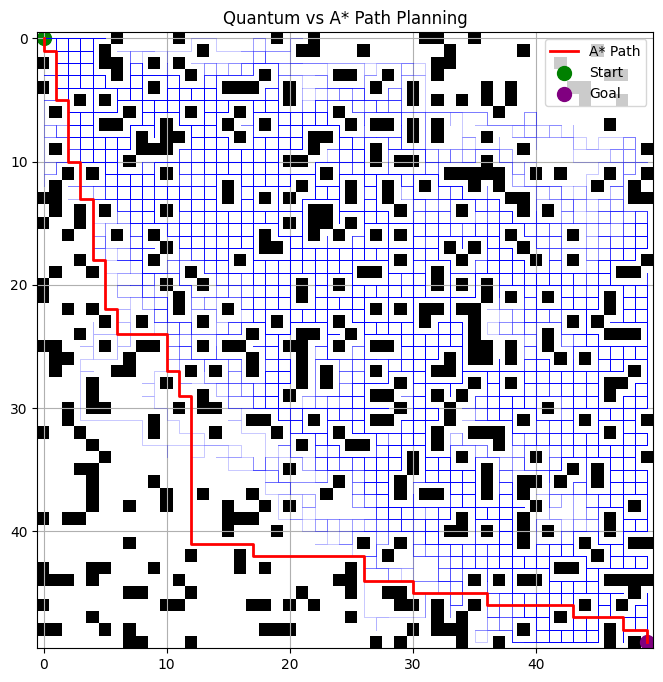

In [ ]:
width, height = 50, 50
env = GridWorld(width, height, obstacle_density=0.2)

# A*
start_t = time.time()
astar_path = a_star(env, env.start, env.goal)
end_t = time.time()
a_star_time = end_t - start_t

# Quantum Sampling
start_t = time.time()
samples = sample_paths(env.grid, env.start, env.goal, n_samples=1000)
end_t = time.time()
q_time = end_t - start_t

valid_count = len(samples)
print(f"\n✅ Valid Quantum Paths Found: {valid_count} / 1000 = {valid_count / 10:.2f}%")
print(f"Quantum Sampling Time: {q_time:.4f}s")
print(f"A* Path Length: {len(astar_path)} | Time: {a_star_time:.4f}s")

plot_paths(env, samples, astar_path)


In [ ]:
import copy

def simulate_dynamic_environment(env, astar_path, quantum_paths, steps=30, changes_per_step=10):
    a_star_times = []
    quantum_times = []
    reuse_counts = []

    valid_qpaths = quantum_paths.copy()

    for step in range(steps):
        # Step 1: Randomly add obstacles
        for _ in range(changes_per_step):
            x, y = np.random.randint(0, env.width), np.random.randint(0, env.height)
            if (x, y) not in [env.start, env.goal]:
                env.grid[y, x] = 1  # Add obstacle

        # Step 2: Re-run A*
        start_time = time.time()
        new_astar_path = astar(env.grid, env.start, env.goal)
        a_star_times.append(time.time() - start_time)

        # Step 3: Check if any quantum path is still valid
        start_time = time.time()
        reusable = 0
        for path, _, _ in valid_qpaths:
            if all(env.grid[y, x] == 0 for (x, y) in path):
                reusable += 1
        quantum_times.append(time.time() - start_time)
        reuse_counts.append(reusable)

        # Step 4: Filter down valid quantum paths
        valid_qpaths = [p for p in valid_qpaths if all(env.grid[y, x] == 0 for (x, y) in p[0])]

        print(f"Step {step+1:02d} → A* Time: {a_star_times[-1]:.4f}s | Quantum Time: {quantum_times[-1]:.4f}s | Q-Paths Left: {len(valid_qpaths)}")

    return a_star_times, quantum_times, reuse_counts


In [ ]:
# Simulate environment changes and record compute stats
a_star_times = []
quantum_times = []
reuse_counts = []

# Reuse the same quantum paths and grid
current_paths = [s[0] for s in samples]  # extract path only
current_grid = env.grid.copy()

for step in range(50):  # Simulate 50 steps
    # Add random obstacle
    x, y = np.random.randint(env.width), np.random.randint(env.height)
    current_grid[y, x] = 1

    # A* timing
    t0 = time.time()
    path_astar = astar(current_grid, env.start, env.goal)
    t1 = time.time()
    a_star_times.append(t1 - t0)

    # Quantum fallback filtering
    t2 = time.time()
    filtered = [p for p in current_paths if all(current_grid[y, x] == 0 for (x, y) in p)]
    reuse_counts.append(len(filtered))
    quantum_times.append(time.time() - t2)

    # Reduce quantum paths for next step
    current_paths = filtered

    print(f"Step {step+1:02d} → A* Time: {a_star_times[-1]:.4f}s | Quantum Time: {quantum_times[-1]:.4f}s | Q-Paths Left: {len(current_paths)}")


Step 01 → A* Time: 0.0076s | Quantum Time: 0.0187s | Q-Paths Left: 186
Step 02 → A* Time: 0.0081s | Quantum Time: 0.0103s | Q-Paths Left: 100
Step 03 → A* Time: 0.0066s | Quantum Time: 0.0090s | Q-Paths Left: 100
Step 04 → A* Time: 0.0075s | Quantum Time: 0.0102s | Q-Paths Left: 100
Step 05 → A* Time: 0.0072s | Quantum Time: 0.0099s | Q-Paths Left: 93
Step 06 → A* Time: 0.0072s | Quantum Time: 0.0089s | Q-Paths Left: 93
Step 07 → A* Time: 0.0064s | Quantum Time: 0.0079s | Q-Paths Left: 82
Step 08 → A* Time: 0.0063s | Quantum Time: 0.0072s | Q-Paths Left: 82
Step 09 → A* Time: 0.0062s | Quantum Time: 0.0074s | Q-Paths Left: 82
Step 10 → A* Time: 0.0062s | Quantum Time: 0.0073s | Q-Paths Left: 82
Step 11 → A* Time: 0.0062s | Quantum Time: 0.0072s | Q-Paths Left: 82
Step 12 → A* Time: 0.0073s | Quantum Time: 0.0134s | Q-Paths Left: 82
Step 13 → A* Time: 0.0111s | Quantum Time: 0.0103s | Q-Paths Left: 67
Step 14 → A* Time: 0.0080s | Quantum Time: 0.0061s | Q-Paths Left: 67
Step 15 → A* Tim

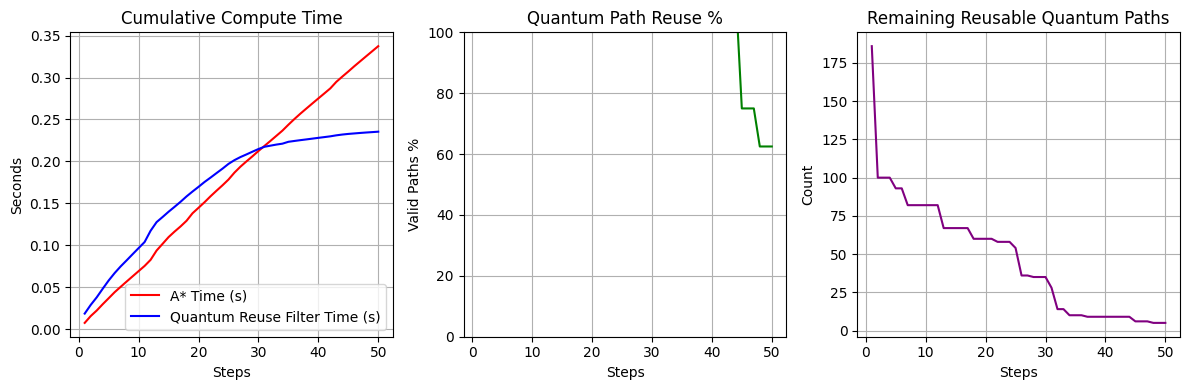

In [ ]:
import matplotlib.pyplot as plt

# === Compute cumulative stats ===
cumulative_astar = np.cumsum(a_star_times)
cumulative_quantum = np.cumsum(quantum_times)
reuse_percent = [r / len(valid_paths) * 100 for r in reuse_counts]


steps = list(range(1, len(a_star_times) + 1))

# === Plot Total Time Comparison ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(steps, cumulative_astar, label='A* Time (s)', color='red')
plt.plot(steps, cumulative_quantum, label='Quantum Reuse Filter Time (s)', color='blue')
plt.title("Cumulative Compute Time")
plt.xlabel("Steps")
plt.ylabel("Seconds")
plt.legend()
plt.grid(True)

# === Plot Quantum Reuse % Over Time ===
plt.subplot(1, 3, 2)
plt.plot(steps, reuse_percent, color='green')
plt.title("Quantum Path Reuse %")
plt.xlabel("Steps")
plt.ylabel("Valid Paths %")
plt.ylim(0, 100)
plt.grid(True)

# === Plot Decay of Valid Paths ===
plt.subplot(1, 3, 3)
plt.plot(steps, reuse_counts, color='purple')
plt.title("Remaining Reusable Quantum Paths")
plt.xlabel("Steps")
plt.ylabel("Count")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter
import math

def compute_entropy(coords, grid):
    if len(coords) < 3:
        return float('inf')
    entropy = 0
    for i in range(1, len(coords)-1):
        x0, y0 = coords[i-1]
        x1, y1 = coords[i]
        x2, y2 = coords[i+1]
        turn = abs((x2-x1)-(x1-x0)) + abs((y2-y1)-(y1-y0))
        entropy += turn * 0.5
        for dx in [-1,0,1]:
            for dy in [-1,0,1]:
                nx, ny = x1 + dx, y1 + dy
                if 0 <= nx < grid.shape[1] and 0 <= ny < grid.shape[0] and grid[ny, nx] == 1:
                    entropy += 1.0
    return entropy / len(coords)



entropy_threshold = 4.0
entropy_scores = [compute_entropy(p[0], env.grid) for p in quantum_paths]  # ✅
filtered_paths = [p for p, score in zip(quantum_paths, entropy_scores) if score <= entropy_threshold]

print(f"🔎 {len(filtered_paths)} / {len(quantum_paths)} quantum paths passed entropy filtering ({len(filtered_paths)/len(quantum_paths)*100:.2f}%)")




🔎 186 / 186 quantum paths passed entropy filtering (100.00%)


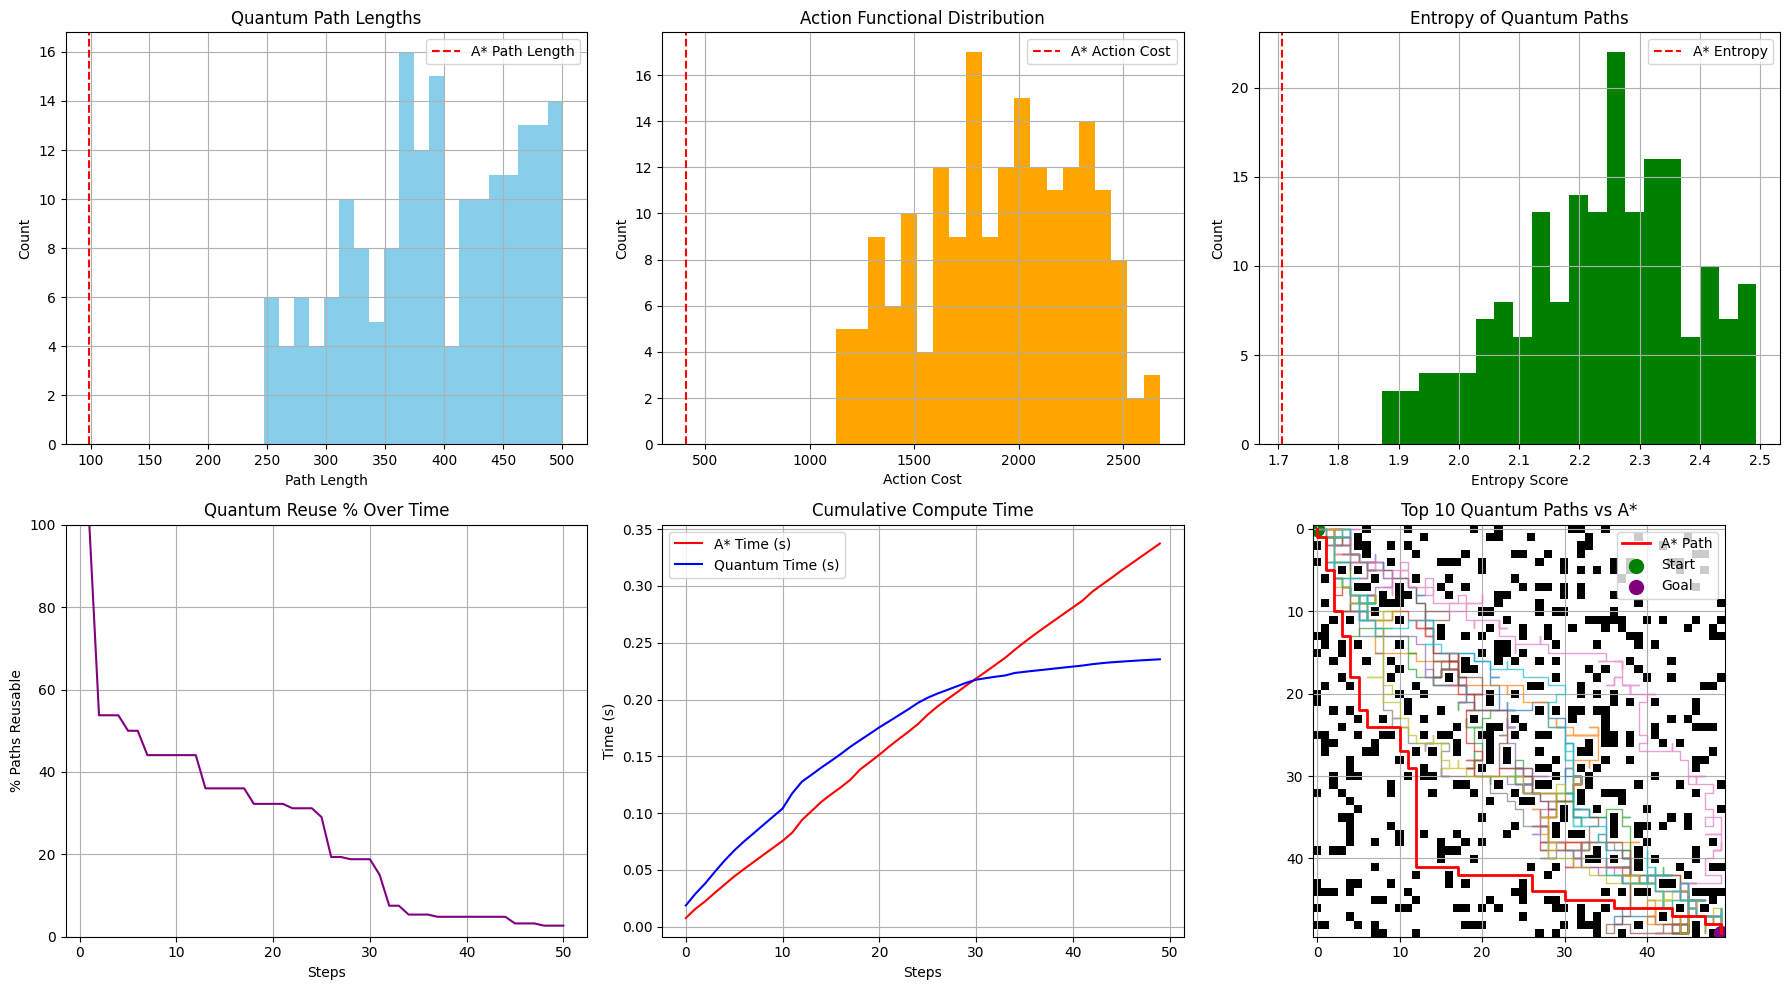

In [ ]:
import matplotlib.pyplot as plt

# === Pull quantum path data ===
path_lengths = [len(p[0]) for p in quantum_paths]
action_costs = [p[2] for p in quantum_paths]
entropy_scores = [compute_entropy(p[0], env.grid) for p in quantum_paths]

# === Compute stats ===
astar_length = len(astar_path)
astar_cost = action_functional(astar_path, env.grid)
astar_entropy = compute_entropy(astar_path, env.grid)

# === Top 10 paths based on cost (least action functional) ===
top_indices = np.argsort(action_costs)[:10]
top_paths = [quantum_paths[i][0] for i in top_indices]

# === Plotting Suite ===
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# 1. 📈 Path Length Distribution
axs[0, 0].hist(path_lengths, bins=20, color='skyblue')
axs[0, 0].axvline(astar_length, color='red', linestyle='--', label='A* Path Length')
axs[0, 0].set_title("Quantum Path Lengths")
axs[0, 0].set_xlabel("Path Length")
axs[0, 0].set_ylabel("Count")
axs[0, 0].legend()
axs[0, 0].grid(True)

# 2. 🧮 Action Functional Cost Distribution
axs[0, 1].hist(action_costs, bins=20, color='orange')
axs[0, 1].axvline(astar_cost, color='red', linestyle='--', label='A* Action Cost')
axs[0, 1].set_title("Action Functional Distribution")
axs[0, 1].set_xlabel("Action Cost")
axs[0, 1].set_ylabel("Count")
axs[0, 1].legend()
axs[0, 1].grid(True)

# 3. 🔥 Entropy Distribution
axs[0, 2].hist(entropy_scores, bins=20, color='green')
axs[0, 2].axvline(astar_entropy, color='red', linestyle='--', label='A* Entropy')
axs[0, 2].set_title("Entropy of Quantum Paths")
axs[0, 2].set_xlabel("Entropy Score")
axs[0, 2].set_ylabel("Count")
axs[0, 2].legend()
axs[0, 2].grid(True)

# 4. 📉 Reuse % Over Time
axs[1, 0].plot(range(1, len(reuse_counts)+1), [r/len(quantum_paths)*100 for r in reuse_counts], color='purple')
axs[1, 0].set_title("Quantum Reuse % Over Time")
axs[1, 0].set_xlabel("Steps")
axs[1, 0].set_ylabel("% Paths Reusable")
axs[1, 0].set_ylim(0, 100)
axs[1, 0].grid(True)

# 5. ⏱️ Cumulative Compute Time
axs[1, 1].plot(np.cumsum(a_star_times), label='A* Time (s)', color='red')
axs[1, 1].plot(np.cumsum(quantum_times), label='Quantum Time (s)', color='blue')
axs[1, 1].set_title("Cumulative Compute Time")
axs[1, 1].set_xlabel("Steps")
axs[1, 1].set_ylabel("Time (s)")
axs[1, 1].legend()
axs[1, 1].grid(True)

# 6. 🧭 Plot Top 10 Quantum Paths
axs[1, 2].imshow(env.grid, cmap='gray_r')
for path in top_paths:
    xs, ys = zip(*path)
    axs[1, 2].plot(xs, ys, linewidth=1, alpha=0.7)
axs[1, 2].plot(*zip(*astar_path), color='red', linewidth=2, label='A* Path')
axs[1, 2].scatter(*env.start, c='green', s=100, label='Start')
axs[1, 2].scatter(*env.goal, c='purple', s=100, label='Goal')
axs[1, 2].legend()
axs[1, 2].set_title("Top 10 Quantum Paths vs A*")
axs[1, 2].grid(True)

plt.tight_layout()
plt.show()
